In [50]:
## import libraries

import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime,timedelta,date
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import random
import math
import h5py
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [2]:
### import photo_interpretations ground truth shapefile

path_file = 'grasslands_photo_interpretations.shp'

dbf = gpd.GeoDataFrame.from_file(filename=path_file,driver='ESRI Shapefile')
print(dbf.shape)
dbf.head()

(599, 14)


,parcel_id,mow_n,m1_dstart,m1_dend,m1_perc,m2_dstart,m2_dend,m2_perc,m3_dstart,m3_dend,m3_perc,Area,Region,geometry
0,1002958865-220542-7422-3,1,2020-06-13,2020-06-18,100.0,None,None,None,None,None,None,1.57,Region 5,"POLYGON ((2747608.596 7581677.906, 2747610.986..."
1,1002960032-220544-9748-2,1,2020-06-08,2020-06-18,100.0,None,None,None,None,None,None,3.56,Region 5,"POLYGON ((2751301.752 7582474.301, 2751307.286..."
2,1002960032-220544-9964-1,1,2020-06-08,2020-06-18,100.0,None,None,None,None,None,None,9.90,Region 5,"POLYGON ((2751776.331 7582641.542, 2751777.481..."
3,1002960032-221544-1539-5,1,2020-06-08,2020-06-18,100.0,None,None,None,None,None,None,5.73,Region 5,"POLYGON ((2751349.079 7582736.911, 2751352.140..."
4,1002995073-201555-7639-1,1,2020-06-20,2020-06-23,100.0,None,None,None,None,None,None,11.99,Region 5,"POLYGON ((2770003.912 7546994.652, 2770271.185..."


In [3]:
## mowing events per parcel dictionary

mowing_events = {}
for case in tqdm(range(dbf.shape[0])):
    case_events_start = [pd.to_datetime(x) for x in dbf.filter(regex='dstart').iloc[case].dropna().values]
    case_events_end = [pd.to_datetime(x) for x in dbf.filter(regex='dend').iloc[case].dropna().values]
    mowing_events[dbf.parcel_id.values[case]] = list(zip(case_events_start,case_events_end))

100%|████████████████████████████████████████| 599/599 [00:01<00:00, 361.42it/s]


In [4]:
case = 77
print(dbf.iloc[case])

parcel_id                             1003587499-147334-0995-1
mow_n                                                        1
m1_dstart                                           2020-06-13
m1_dend                                             2020-06-18
m1_perc                                                  100.0
m2_dstart                                                 None
m2_dend                                                   None
m2_perc                                                   None
m3_dstart                                                 None
m3_dend                                                   None
m3_perc                                                   None
Area                                                     11.18
Region                                                Region 2
geometry     POLYGON ((2381364.374899644 7446715.930240131,...
Name: 77, dtype: object


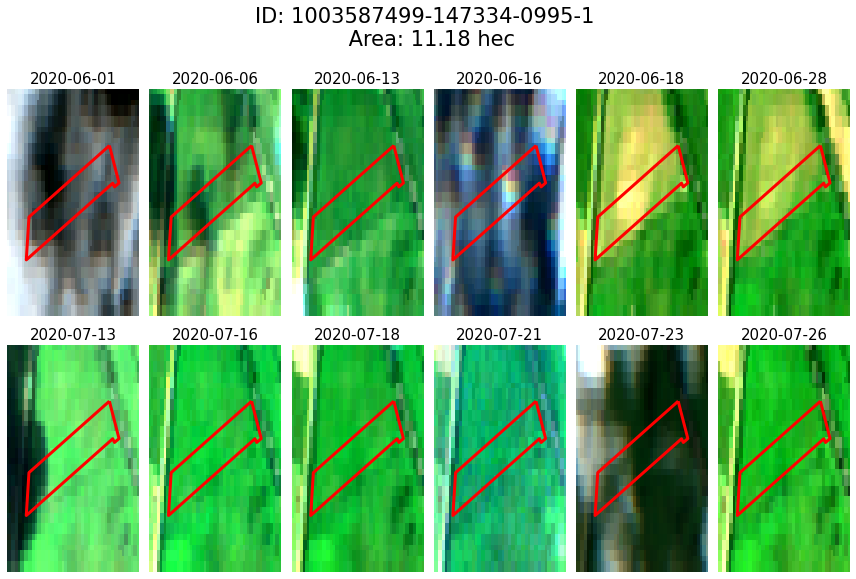

In [5]:
datacube_parcel(case,dbf,'2020-06-01','2020-08-01',path=path_file)

In [6]:
dataset = h5py.File('mowing_detection_dataset.h5', 'r')
X = np.array(dataset['X']).copy()
y = np.array(dataset['y_interp']).copy()
pixel_id = np.array(dataset['pixel_id']).astype('str').copy()
parcel_id = np.array(dataset['parcel_id']).astype('str').copy()
regions = np.array(dataset['regions']).astype('str').copy()
dataset.close()

ii = np.argsort(pixel_id)
X = X[ii]
y = y[ii]
pixel_id = pixel_id[ii]
parcel_id = parcel_id[ii]
regions = regions[ii]

In [7]:
year = 2020
dates = pd.date_range(start='04/09/{}'.format(year), end='24/09/{}'.format(year),freq='6d')
dates_str = [str(d).split(' ')[0] for d in dates]

In [8]:
d_start_list = [d[0][0] for d in mowing_events.values()]
d_end_list = [d[0][1] for d in mowing_events.values()]

events_dates = np.sort(np.unique(d_start_list))
freq_days = 6
matching_mowing_days = {d:[(x-d).days for x in dates if (x-d).days in np.arange(-freq_days//2,freq_days//2)] for d in events_dates}
matching_mowing_days = {k:sorted(v, key=abs) for k,v in matching_mowing_days.items() if len(v) != 0} 
matching_mowing_days = {k:k+timedelta(days = v[0]) for k,v in matching_mowing_days.items()}

y_when = []
for parcel_id_case in tqdm(sorted(np.unique(parcel_id))):

    events = [mowing_events[parcel_id_case][0][0]]
    n_cases = len(np.where(parcel_id==parcel_id_case)[0])

    y_i = np.zeros(len(dates))
    for e in events:
        date_i = matching_mowing_days[e]
        y_i[np.where(dates==date_i)[0]] = 1

    for _ in range(n_cases):
        y_when.append(y_i.T)
        
y_when = np.array(y_when)
print(y_when.shape)

100%|████████████████████████████████████████| 599/599 [00:02<00:00, 288.74it/s]


(190569, 29)


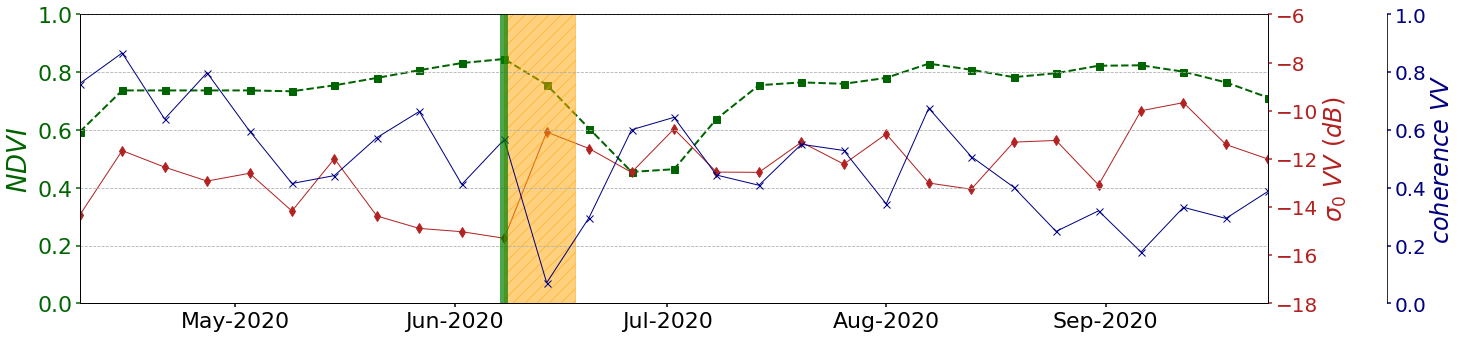

In [9]:
cc = 43
plot_parcel(dates,mowing_events[parcel_id[cc]],y[cc],X[cc,:,0],X[cc,:,4],y_when[cc])

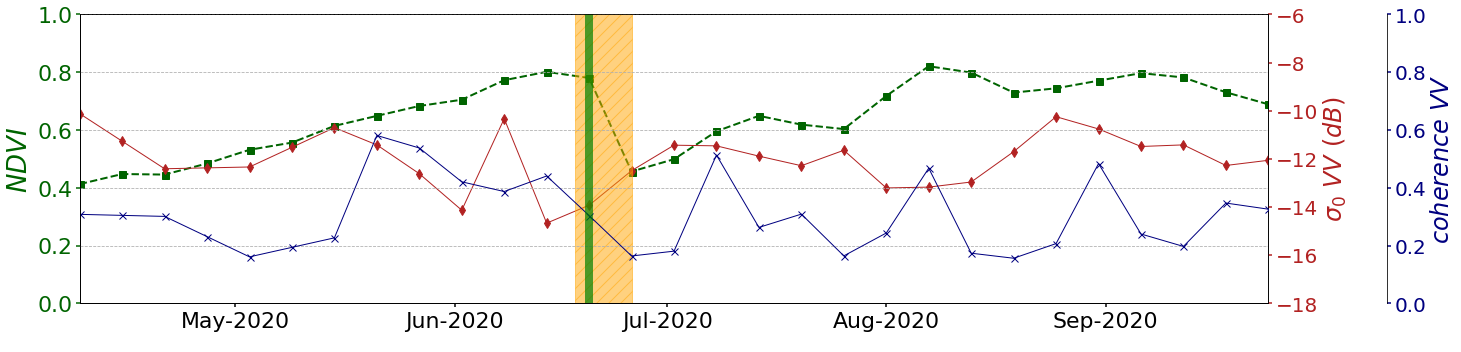

In [11]:
c = 23
case = sorted(np.unique(parcel_id))[c]
cc = np.where(parcel_id==case)[0]
plot_parcel(dates,mowing_events[case],y[cc].mean(axis=0),X[cc,:,0].mean(axis=0),X[cc,:,4].mean(axis=0),
            y_when[cc].mean(axis=0))

In [12]:
ndvi = pd.DataFrame(columns=dates,data=y)
vv = pd.DataFrame(columns=dates,data=X[:,:,0])
vh = pd.DataFrame(columns=dates,data=X[:,:,1])
cross_sar = pd.DataFrame(columns=dates,data=X[:,:,2])
ratio_sar = cross_sar = pd.DataFrame(columns=dates,data=X[:,:,3])
vv_insar = pd.DataFrame(columns=dates,data=X[:,:,4])
vh_insar = pd.DataFrame(columns=dates,data=X[:,:,5])
insar_mixed = pd.DataFrame(columns=dates,data=X[:,:,6])
rvi = vv/(vv+vh)
vv_diff = vv.diff(axis=1).fillna(0)
vh_diff = vv.diff(axis=1).fillna(0)

X = []
for k in tqdm(range(ndvi.shape[0])):
    k_1 = []
    for l in range(ndvi.shape[1]):
        inputs = [vv.values[k,l],vh.values[k,l],
                  cross_sar.values[k,l],ratio_sar.values[k,l],rvi.values[k,l],
                  vv_diff.values[k,l],vh_diff.values[k,l],
                  vv_insar.values[k,l],vh_insar.values[k,l],insar_mixed.values[k,l],ndvi.values[k,l]]
        k_1.append(inputs)
    X.append(k_1)

X = np.array(X)

100%|██████████████████████████████████| 190569/190569 [06:49<00:00, 465.82it/s]


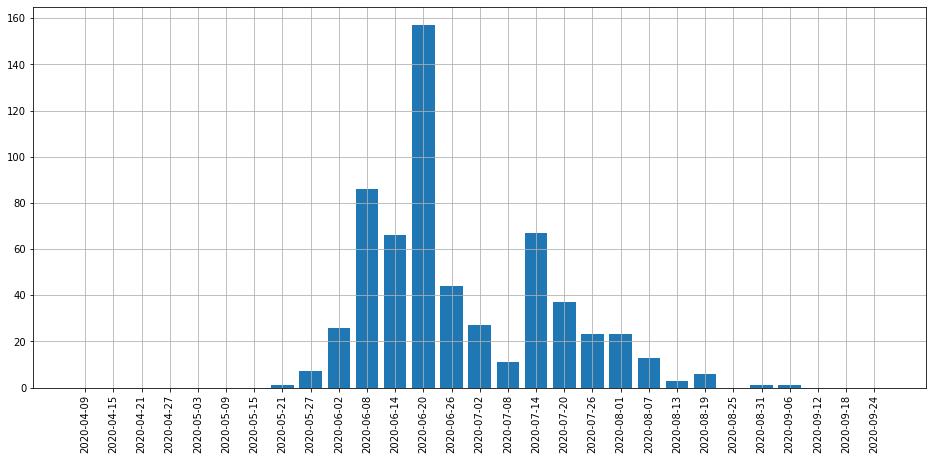

In [13]:
df_dates = pd.DataFrame(y_when,columns=dates_str)
df_dates['parcel_id'] = parcel_id
df_dates = df_dates.groupby('parcel_id').max()
y_when_2 = df_dates.values

plt.figure(figsize=(16,7))
plt.bar(dates_str,y_when_2.sum(axis=0))
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [14]:
bag_of_cases = []
id_cases = y_when_2.argmax(axis=1).copy()
max_cases = y_when_2.sum(axis=0)
for i in range(len(dates)):
    ii = np.where(id_cases==i)[0]
    if max_cases[i]>20:
        bag_of_cases.extend(np.random.choice(ii,15,replace=False))
    elif max_cases[i]>10:
        bag_of_cases.extend(np.random.choice(ii,8,replace=False))
    elif max_cases[i]>5:
        bag_of_cases.extend(np.random.choice(ii,5,replace=False))
    elif max_cases[i]>2:
        bag_of_cases.extend(np.random.choice(ii,2,replace=False))
    elif max_cases[i]>0:
        bag_of_cases.extend(ii)
    else:
        continue
bag_of_cases = np.array(sorted(bag_of_cases))
print(len(bag_of_cases))

181


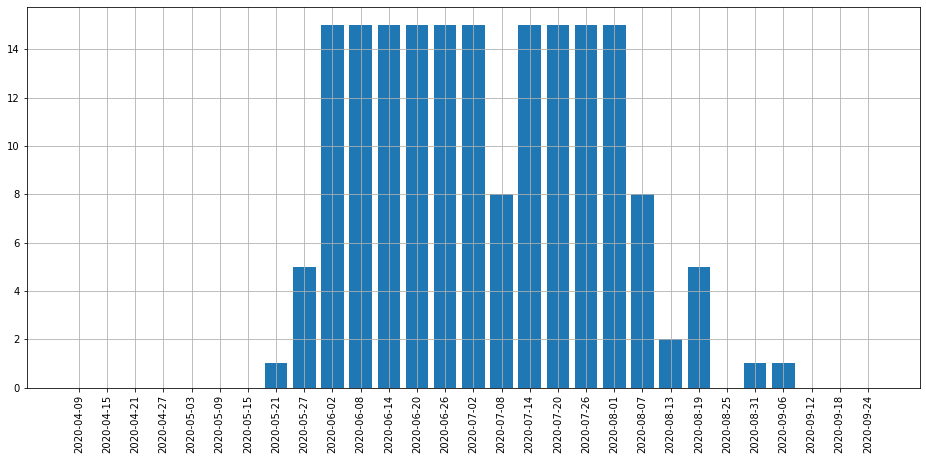

In [15]:
plt.figure(figsize=(16,7))
plt.bar(dates_str,y_when_2[bag_of_cases].sum(axis=0))
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [16]:
# id_train = np.array(sorted(set(parcel_id)))[bag_of_cases]

# ids_num_train = np.array(sorted(np.where(np.isin(parcel_id,id_train))[0]))
# np.random.shuffle(ids_num_train)
# ids_num_test = np.array(sorted([i for i in range(y_when.shape[0]) if i not in ids_num_train]))

# np.savetxt("ids_num_test.csv", ids_num_test, delimiter=",")
# np.savetxt("ids_num_train.csv", ids_num_train, delimiter=",")

ids_num_train = np.genfromtxt('ids_num_train.csv', delimiter=',', dtype=None).astype(int)
ids_num_test = np.genfromtxt('ids_num_test.csv', delimiter=',', dtype=None).astype(int)

In [17]:
X_train, X_test = X[ids_num_train], X[ids_num_test]
y_train, y_test = y[ids_num_train], y[ids_num_test]
y_when_train, y_when_test = y_when[ids_num_train], y_when[ids_num_test]
parcel_id_train, parcel_id_test = parcel_id[ids_num_train], parcel_id[ids_num_test]
pixel_id_train, pixel_id_test = pixel_id[ids_num_train], pixel_id[ids_num_test]
regions_train, regions_test = regions[ids_num_train], regions[ids_num_test]

In [18]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(len(set(parcel_id_train)))
print(len(set(parcel_id_test)))

(190569, 29, 11)
(52468, 29, 11)
(138101, 29, 11)
181
418


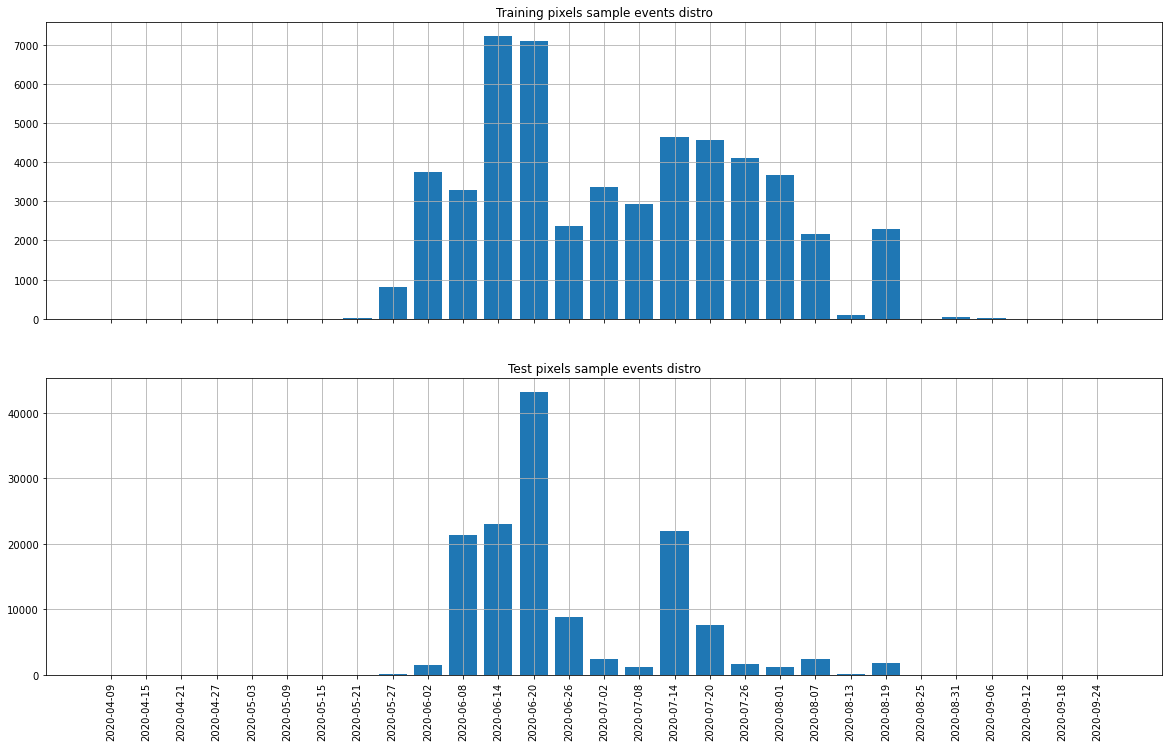

In [19]:
fig, ax = plt.subplots(figsize=(20,12),nrows=2,sharex=True) 
ax[0].bar(dates_str,y_when_train.sum(axis=0))
ax[1].bar(dates_str,y_when_test.sum(axis=0))
ax[0].set_title('Training pixels sample events distro')
ax[1].set_title('Test pixels sample events distro')
ax[0].grid()
ax[1].grid()
plt.xticks(rotation=90)
plt.show()

In [20]:
X_new = []
X_new_train = []
X_new_test = []

for i in tqdm(range(X.shape[2])):
    X_new.append(X[:,:,i].copy())
    X_new_train.append(X_train[:,:,i].copy())
    X_new_test.append(X_test[:,:,i].copy())

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.56it/s]


In [21]:
# masks_when_train = np.ones(y_when_train.shape)
# masks_when_test = np.ones(y_when_test.shape)
# masks_when_train[y_when_train==0] = 0.2

In [22]:
# ver = 0
# metric = 'val_loss'
# mode = 'min'

# def scheduler(epoch,lr):
#     initial_lrate = 0.001
#     drop = 0.2
#     epochs_drop = 10.0
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
#     return lrate

# # change_lr = LearningRateScheduler(scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=ver)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=ver, patience=7)

In [23]:
n_vars = X.shape[2]
n_timesteps = X.shape[1]
# lstm_units = n_timesteps
# l_rate = 0.001

# tf.keras.backend.clear_session()
# mowing_model = Conv_RNN_mowing_model_when(n_vars,n_timesteps,lstm_units)
# mowing_model.save('models/Mowing_model.h5')
# mowing_model.compile(loss={'when_out':losses.BinaryCrossentropy()},
#                           optimizer=optimizers.Adam(learning_rate=l_rate),
#                           metrics={'when_out':['accuracy',tf.keras.metrics.Precision(), 
#                                                tf.keras.metrics.Recall(),f1_when]})
# mowing_model.summary()

In [24]:
# batch_size = 64
# epochs = 15
# ver = 0

# history = mowing_model.fit(X_new_train,y_when_train.reshape(-1,n_timesteps,1),
#                            batch_size=batch_size,
#                            validation_data=(X_new_test, y_when_test.reshape(-1,n_timesteps,1)),
#                            sample_weight=masks_when_train.reshape(-1,n_timesteps,1),
#                            epochs=epochs,
#                            callbacks=[reduce_lr],verbose=ver)
# mowing_model.save_weights('models/Mowing_model_weights.h5')

In [25]:
mowing_model = load_model('models/Mowing_model.h5')
mowing_model.load_weights('models/Mowing_model_weights.h5')

2022-11-09 14:22:13.641060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-11-09 14:22:13.641144: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 14:22:13.641228: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (envision2): /proc/driver/nvidia/version does not exist


In [26]:
ground_truth = {}
for c in tqdm(pixel_id_test):
    c = '-'.join(c.split('-')[:-1])
    dd = pd.date_range(mowing_events[c][0][0],mowing_events[c][0][1])
    ground_truth[c] = mowing_events[c][0][0]

100%|█████████████████████████████████| 138101/138101 [00:40<00:00, 3400.71it/s]


In [27]:
logits_clf = mowing_model.predict(X_new_test).reshape(-1,n_timesteps)
preds_clf = logits_clf.copy()
preds_clf[preds_clf>=0.5] = 1
preds_clf[preds_clf<0.5] = 0 

In [28]:
proximity = 18
results_mowing = results_refinement(preds_clf,pixel_id_test,proximity,dates)

In [29]:
tolerance = 12
perf = mowing_performance(results_mowing,ground_truth,tolerance)

support: 138101
Recall: 0.949
Precision: 0.937
f1_score: 0.943
ME: 0.245
MAE: 2.978
R^2: 0.971


In [37]:
predictions_mowing_parcel, perf_parcel = results_aggr(results_mowing,ground_truth,
                                                      perc_tolerance=0.5,tolerance=tolerance)

support: 418
Recall: 0.931
Precision: 0.924
f1_score: 0.927
ME: -0.005
MAE: 3.558
R^2: 0.959


In [44]:
parcel_id_test_unique = np.sort(np.unique(parcel_id_test))

X_mean = []
for c in parcel_id_test_unique:
    ii = np.where(parcel_id_test==c)[0]
    X_mean.append(X_test[ii,:,:].mean(axis=0))
X_mean = np.array(X_mean)

X_new_mean = []
for i in tqdm(range(X_mean.shape[2])):
    X_new_mean.append(X_mean[:,:,i].copy())

100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7182.03it/s]


In [46]:
logits_clf_mean = mowing_model.predict(X_new_mean).reshape(-1,n_timesteps)
preds_clf_mean = logits_clf_mean.copy()
preds_clf_mean[preds_clf_mean>=0.5] = 1
preds_clf_mean[preds_clf_mean<0.5] = 0 

In [62]:
results_mowing_mean = results_refinement(preds_clf_mean,parcel_id_test_unique,proximity,dates)
perf_mean = mowing_performance(results_mowing_mean,ground_truth,tolerance,pixel_lvl=False)

support: 418
Recall: 0.94
Precision: 0.929
f1_score: 0.934
ME: 0.097
MAE: 2.855
R^2: 0.969


In [67]:
c = 15
case = sorted(np.unique(parcel_id_test))[c]
print(case)
print(mowing_events[case])

1003188696-219544-2391-1
[(Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-18 00:00:00'))]


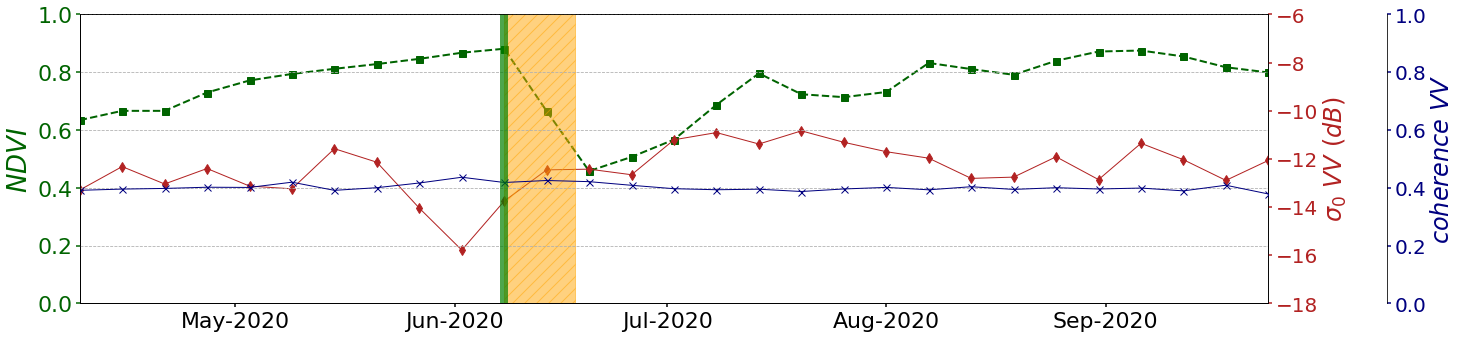

In [68]:
cc = np.where(parcel_id_test==case)[0]
yy = np.zeros(n_timesteps)
for c in predictions_mowing_parcel[case]:
    d_0,d_1 = c
    yy[np.where(dates==d_0)[0]] = 1
plot_parcel(dates,mowing_events[case],y_test[cc].mean(axis=0),X_test[cc,:,0].mean(axis=0),
            X_test[cc,:,4].mean(axis=0),yy)

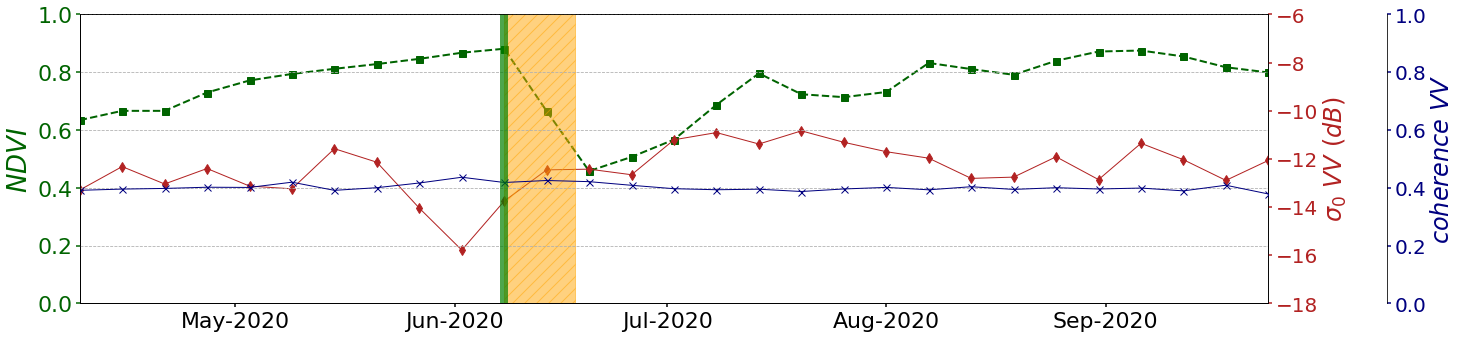

In [69]:
cc = np.where(parcel_id_test==case)[0]
yy = np.zeros(n_timesteps)
for c in results_mowing_mean[case]:
    d_0,d_1 = c
    yy[np.where(dates==d_0)[0]] = 1
plot_parcel(dates,mowing_events[case],y_test[cc].mean(axis=0),X_test[cc,:,0].mean(axis=0),
            X_test[cc,:,4].mean(axis=0),yy)

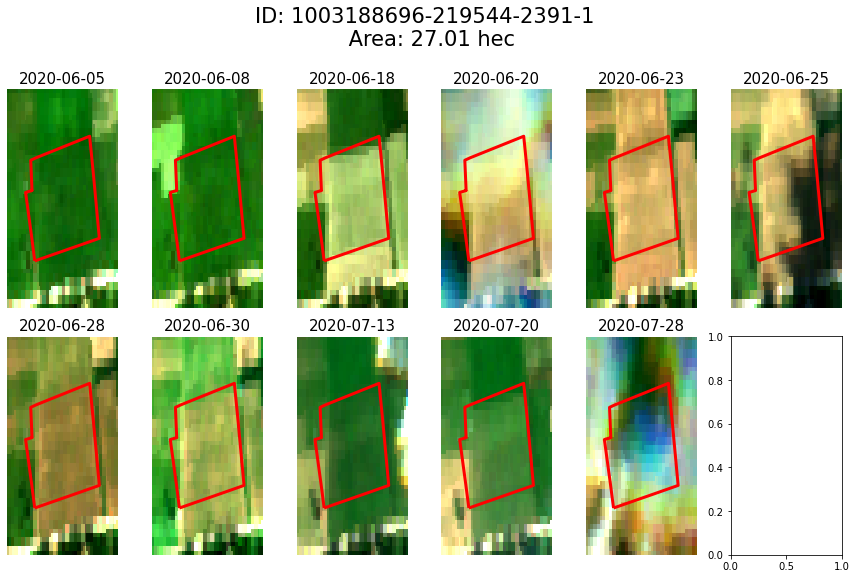

In [71]:
case_i = int(np.where(np.sort(np.unique(parcel_id))==case)[0][0])
datacube_parcel(case_i,dbf,'2020-06-01','2020-08-01',path=path_file)